## Foraging Analyses
This script is inspired by analyses from "Professional Jazz Musicians Explore and Exploit a Space of Sounds" (Williams et al., 2024) and examines euclidean distance and cosine similarity patterns across all transcripts.

**Author:** Helen Schmidt  
**Python version:** 3.11.13

In [1]:
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import convolve

/opt/anaconda3/envs/myenv-python3-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define data input location
input_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/CANDOR/transcripts/raw"
# define data output location
output_dir = "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/full-sample"

In [3]:
# load data
df = pd.read_pickle(output_dir + "/full_sample_tile_3_0.pkl")
df.head()

,transcript_id,window_size,gap_size,A_start_turn,A_end_turn,A_utterances,A_embeddings,B_start_turn,B_end_turn,B_utterances,B_embeddings,cosine_similarity,euclidean_distance
0,0020a0c5-1658-4747-99c1-2839e736b481,3,0,1,3,"No, I'm good. How are you? No. Hi, how are you...","[[0.012172122, -0.011064016, 0.06654317, 0.000...",4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",0.315577,1.169977
1,0020a0c5-1658-4747-99c1-2839e736b481,3,0,2,4,"No. Hi, how are you? Good thanks. Hm My name i...","[[-0.0106563475, -0.06792329, 0.064656146, -0....",5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",0.387075,1.107181
2,0020a0c5-1658-4747-99c1-2839e736b481,3,0,3,5,"Good thanks. Hm My name is played to me Hi, my...","[[-0.038483433, -0.0698858, 0.0062682955, -0.0...",6,8,and the next time you Amanda. All right. Does ...,"[[0.044995096, -0.058201604, -0.028326219, -0....",0.442343,1.056084
3,0020a0c5-1658-4747-99c1-2839e736b481,3,0,4,6,"Hm My name is played to me Hi, my name's Amand...","[[-0.03531422, -0.04561006, 0.02838244, -0.076...",7,9,"All right. Does that time start? Yeah, three o...","[[0.043147173, -0.042117808, -0.027217342, -0....",0.176185,1.283600
4,0020a0c5-1658-4747-99c1-2839e736b481,3,0,5,7,"Hi, my name's Amanda. and the next time you Am...","[[-0.0010068159, -0.09045196, -0.0003150229, -...",8,10,"right. At three. Right, What's that? Don't go ...","[[0.043233756, -0.056193333, -0.049202096, -0....",0.408750,1.087428


In [4]:
# get a list of transcripts annotated in the 200 dense subset
dense = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/dense_subset_processed.csv")
dense_transcripts = dense['transcript_id'].unique().tolist()

dense.head()

,transcript_id,turn_id,scaled_turn_id,PID,utterance,currentUtterance,previous_topic,new_topic
0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0,0.00,NaN,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,NaN,NaN,NaN
1,01849238-f5f0-487e-bca4-7b4fe0c9625c,1,0.00,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?","Hello, Can you hear me? I can, how are you doing?",Starting The Call,Greeting
2,01849238-f5f0-487e-bca4-7b4fe0c9625c,2,0.01,NaN,Good. How about you?,NaN,NaN,NaN
3,01849238-f5f0-487e-bca4-7b4fe0c9625c,3,0.01,NaN,"I am doing well, yeah,",NaN,NaN,NaN
4,01849238-f5f0-487e-bca4-7b4fe0c9625c,4,0.01,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,Sweet. So um I guess we could start off by tal...,Greeting,Introductions


### Step Size & Turn Angle

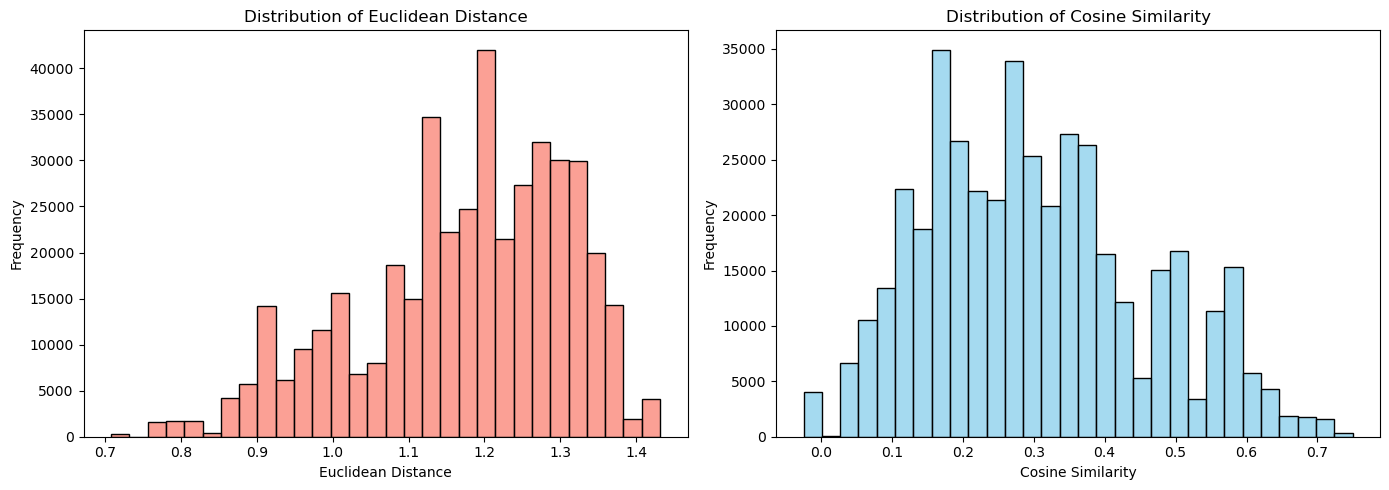

In [5]:
# plot distributions of cosine similarity and euclidean distances
# create figure / axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# plot A - step length (euclidean distance)
sns.histplot(df['euclidean_distance'], bins=30, kde=False, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Euclidean Distance')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Frequency')

# plot B - turn angles (cosine similarity)
sns.histplot(df['cosine_similarity'], bins=30, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Cosine Similarity')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

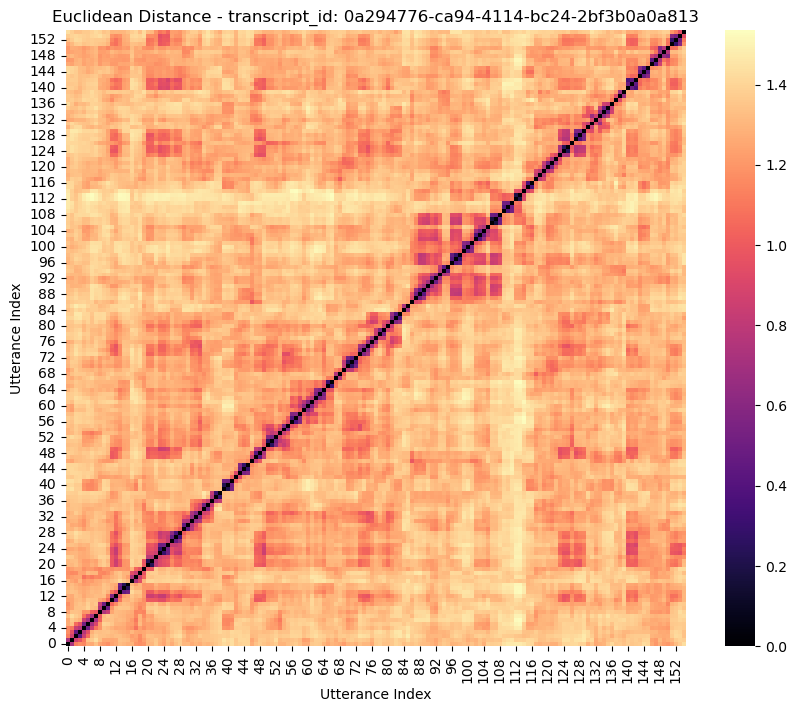

In [6]:
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

embedding_matrix = np.vstack(subset['A_embeddings'].values)

distance_matrix = cdist(embedding_matrix, embedding_matrix, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, cmap='magma')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.gca().invert_yaxis()
plt.xlabel('Utterance Index')
plt.ylabel('Utterance Index')
plt.show()

In [ ]:
# # test subset
# test_df = df.head(1000).copy()

# # create a folder in the full sample data output to save heatmaps
# heatmap_dir = os.path.join(output_dir, "euclidean-distance-heatmaps")
# os.makedirs(heatmap_dir, exist_ok=True)

# # loop through each unique transcript_id
# for transcript_id in df['transcript_id'].unique():
#     subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
#     # add in skip if not enough data exists to compute distances
#     if subset.empty or subset.shape[0] < 2:
#         continue
#     try:
#         # stack embeddings into a matrix
#         embedding_matrix = np.vstack(subset['A_embeddings'].values)
#         # compute pairwise euclidean distance
#         distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "euclidean")
#         # plot heatmap
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(distance_matrix, annot=False, cmap='magma')
#         plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
#         plt.gca().invert_yaxis()
#         plt.xlabel('Utterance Index')
#         plt.ylabel('Utterance Index')
#         # save each plot
#         save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
#         plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
#         plt.savefig(plot_path, bbox_inches='tight')
#         plt.close()

#     except Exception as e:
#         print(f"Error creating heatmap for {transcript_id}: {e}")

In [ ]:
# # test subset
# test_df = df.head(1000).copy()

# # create a folder in the full sample data output to save heatmaps
# heatmap_dir = os.path.join(output_dir, "cosine-similarity-heatmaps")
# os.makedirs(heatmap_dir, exist_ok=True)

# # loop through each unique transcript_id
# for transcript_id in df['transcript_id'].unique():
#     subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)
#     # add in skip if not enough data exists to compute distances
#     if subset.empty or subset.shape[0] < 2:
#         continue
#     try:
#         # stack embeddings into a matrix
#         embedding_matrix = np.vstack(subset['A_embeddings'].values)
#         # compute pairwise cosine similarity
#         distance_matrix = cdist(embedding_matrix, embedding_matrix, metric = "cosine")
#         # plot heatmap
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(distance_matrix, annot=False, cmap='magma')
#         plt.title(f'Cosine Similarity - transcript_id: {transcript_id}')
#         plt.gca().invert_yaxis()
#         plt.xlabel('Utterance Index')
#         plt.ylabel('Utterance Index')
#         # save each plot
#         save_id = transcript_id.replace('/', '_')  # edit ID in case there are problematic characters
#         plot_path = os.path.join(heatmap_dir, f"{save_id}.png")
#         plt.savefig(plot_path, bbox_inches='tight')
#         plt.close()

#     except Exception as e:
#         print(f"Error creating heatmap for {transcript_id}: {e}")

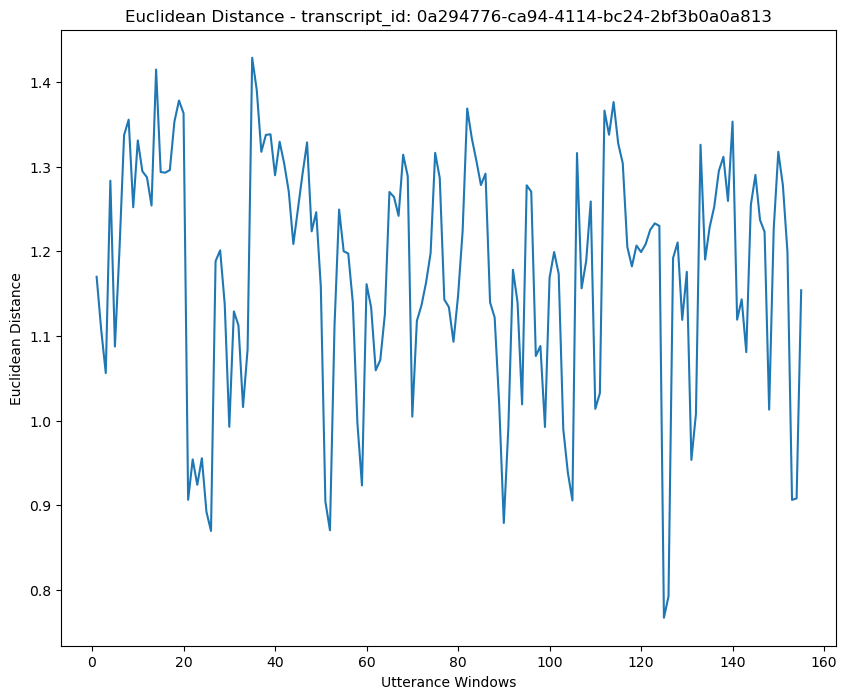

In [7]:
# plot a conversation's peaks of euclidean distances and cosine similarities
transcript_id = '0a294776-ca94-4114-bc24-2bf3b0a0a813'
#transcript_id = '339012e4-ada1-4c88-839d-08a6842b5903'
subset = df[df['transcript_id'] == transcript_id].reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.lineplot(data=subset, x='A_start_turn', y='euclidean_distance')
plt.title(f'Euclidean Distance - transcript_id: {transcript_id}')
plt.xlabel('Utterance Windows')
plt.ylabel('Euclidean Distance')
plt.show()

## Foote Novelty

In [8]:
# foote novelty

all_results = []

for transcript_id, group in df.groupby('transcript_id'):
    # sort by conversation order within each transcript
    group = group.sort_values('A_start_turn').reset_index(drop=True)
    
    # construct full embedding trajectory (starting with first A_embeddings and ending with last B_embeddings)
    embeddings_list = [emb.squeeze() for emb in group['A_embeddings'].values]
    embeddings_list.append(group['B_embeddings'].values[-1].squeeze())
    embeddings = np.vstack(embeddings_list)
    n = embeddings.shape[0]
    if n < 4:
        continue

    # compute the self-similarity matrix (how similar is each embedding to all other embeddings in the convo?)
    # https://ccrma.stanford.edu/workshops/mir2009/references/Foote_00.pdf 
    S = cosine_similarity(embeddings)

    # build the checkerboard kernel
    # thanks GPT for help actually making the checkerboard kernel
    kernel_size = 10  # bigger values = detect larger shifts
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)

    # compute foote novelty
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)

    # normalize the novelty scores to 0-1
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)

    # save results
    temp = pd.DataFrame({
        'transcript_id': transcript_id,
        'turn_index': np.arange(n),   # each embedding position
        'foote_novelty': novelty
    })
    all_results.append(temp)

# Combine all transcripts
foote_df = pd.concat(all_results, ignore_index=True)

In [9]:
# mark predicted shifts when foote novelty is 1.5 SD away from transcript mean foote novelty
foote_df['predicted_shift'] = 0

for tid, group in foote_df.groupby('transcript_id'):
    mean_nov = group['foote_novelty'].mean()
    std_nov  = group['foote_novelty'].std()
    threshold = mean_nov + 1.5 * std_nov
    
    # mark points above threshold
    idx = group.index[group['foote_novelty'] > threshold]
    foote_df.loc[idx, 'predicted_shift'] = 1

In [10]:
# preview
foote_df.head()

,transcript_id,turn_index,foote_novelty,predicted_shift
0,0020a0c5-1658-4747-99c1-2839e736b481,0,0.0,0
1,0020a0c5-1658-4747-99c1-2839e736b481,1,0.0,0
2,0020a0c5-1658-4747-99c1-2839e736b481,2,0.0,0
3,0020a0c5-1658-4747-99c1-2839e736b481,3,0.0,0
4,0020a0c5-1658-4747-99c1-2839e736b481,4,0.0,0


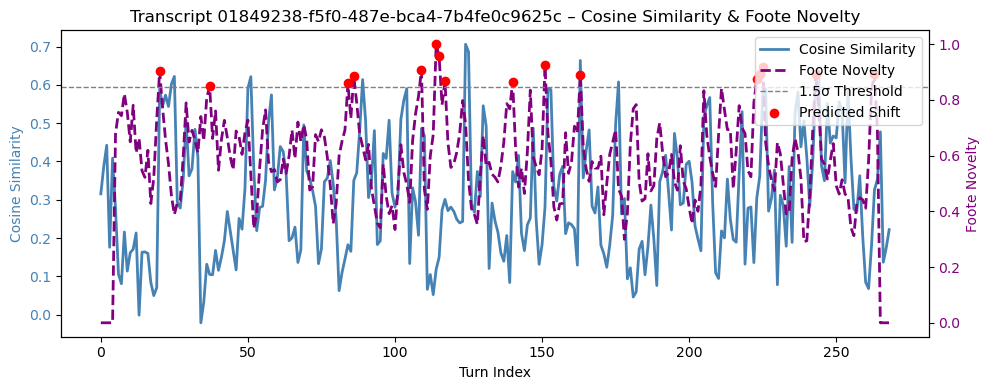

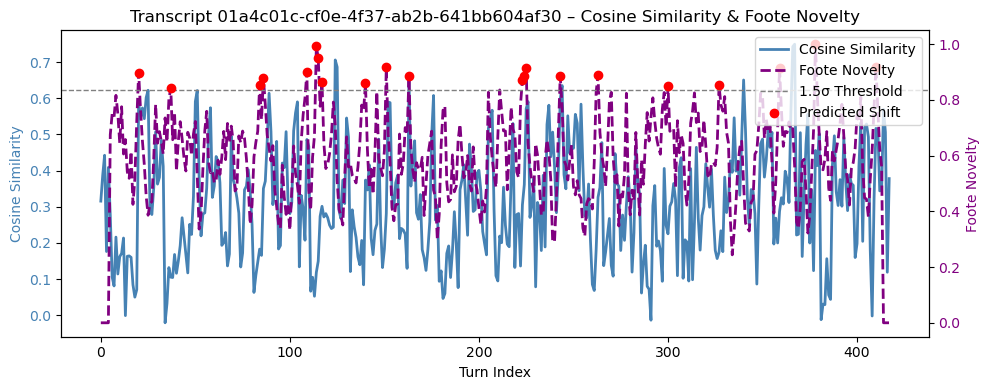

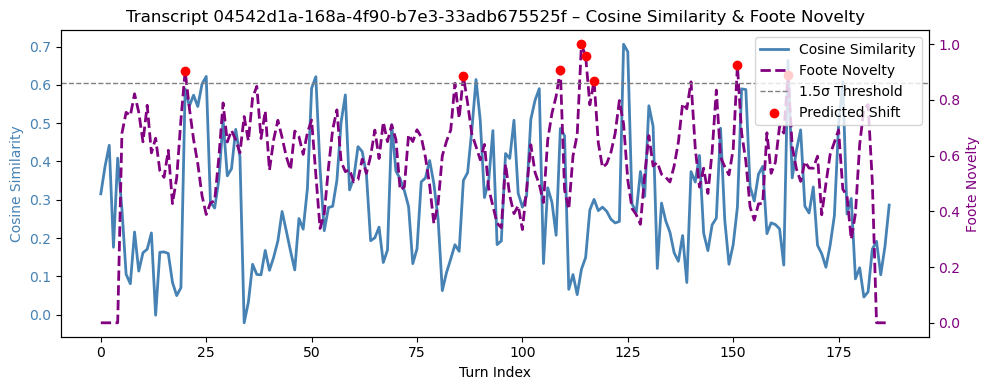

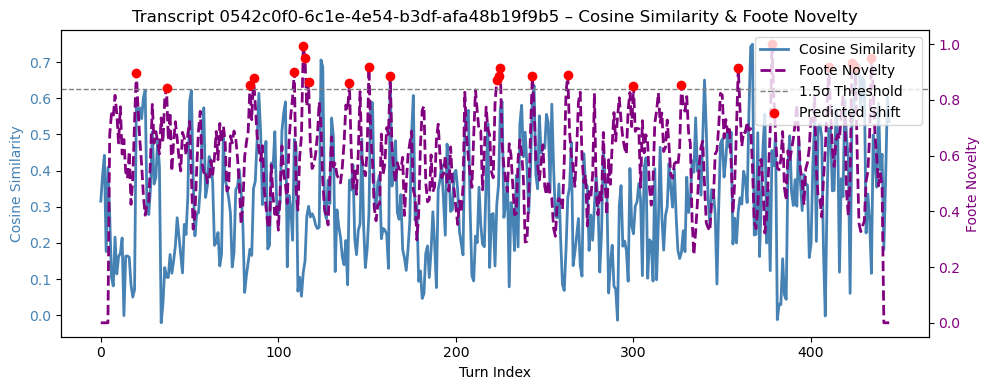

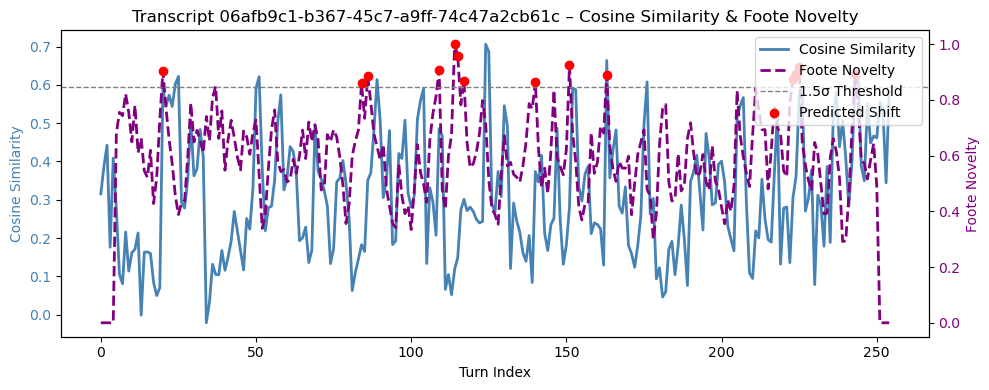

In [19]:
# plot 5 densely annotated transcripts showing cosine similarity and foote novelty
unique_transcripts = dense['transcript_id'].unique().tolist()
example_transcripts = unique_transcripts[:5]

for tid in example_transcripts:
    # get cosine similarity from original df
    cos_df = df[df['transcript_id'] == tid].sort_values('A_start_turn').reset_index(drop=True)
    
    # get Foote novelty from foote_df
    nov_df = foote_df[foote_df['transcript_id'] == tid]
    
    # align lengths in case they differ
    min_len = min(len(cos_df), len(nov_df))
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals = nov_df['foote_novelty'].values[:min_len]
    predicted = nov_df['predicted_shift'].values[:min_len]
    turns = np.arange(min_len)
    
    # compute threshold for this transcript (mean + 1.5 * std)
    threshold = nov_vals.mean() + 1.5 * nov_vals.std()
    
    # plot
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # cosine similarity (left y-axis)
    ax1.plot(turns, cos_vals, color='steelblue', lw=2, label='Cosine Similarity')
    ax1.set_xlabel('Turn Index')
    ax1.set_ylabel('Cosine Similarity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    # foote novelty (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(turns, nov_vals, color='purple', linestyle='--', lw=2, label='Foote Novelty')
    ax2.axhline(threshold, color='gray', ls='--', lw=1, label='1.5σ Threshold')
    ax2.set_ylabel('Foote Novelty', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # mark predicted shift peaks
    peak_idx = np.where(predicted == 1)[0]
    ax2.scatter(turns[peak_idx], nov_vals[peak_idx], color='red', zorder=5, label='Predicted Shift')
    
    plt.title(f'Transcript {tid} – Cosine Similarity & Foote Novelty')
    fig.tight_layout()
    
    # combine legends and plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()


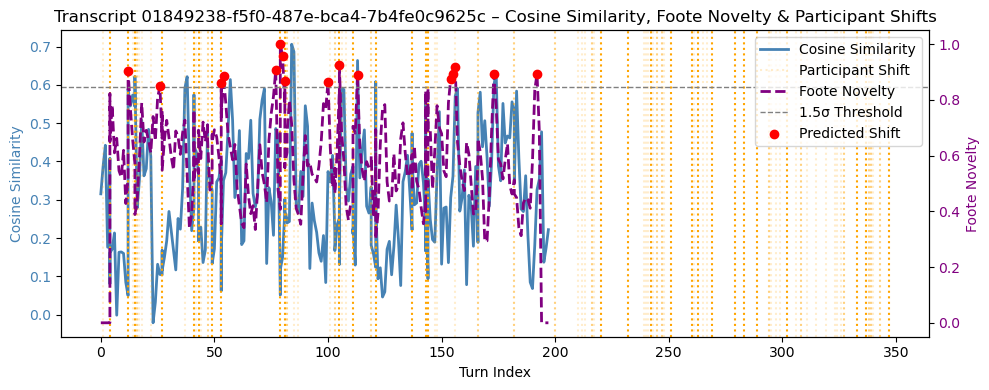

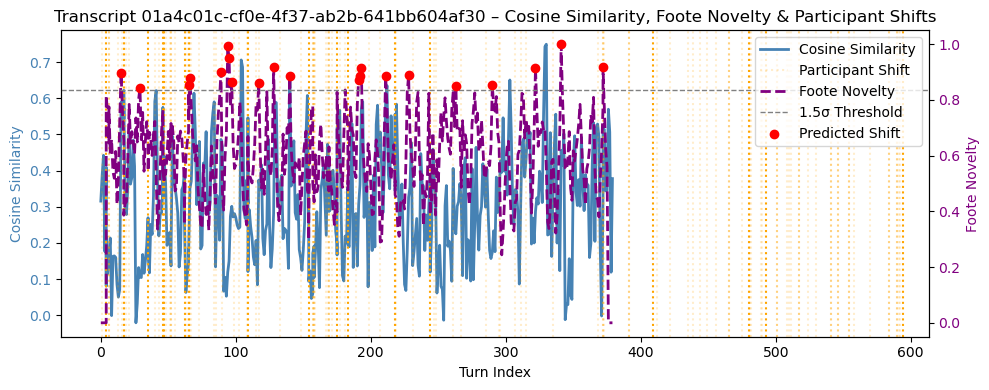

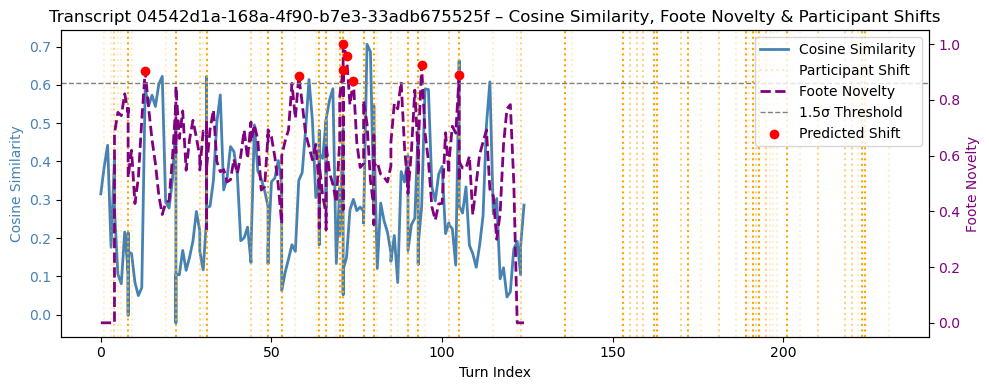

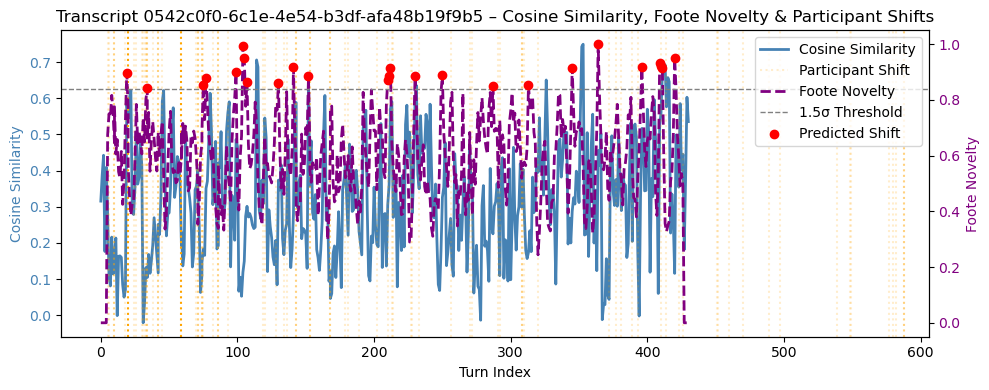

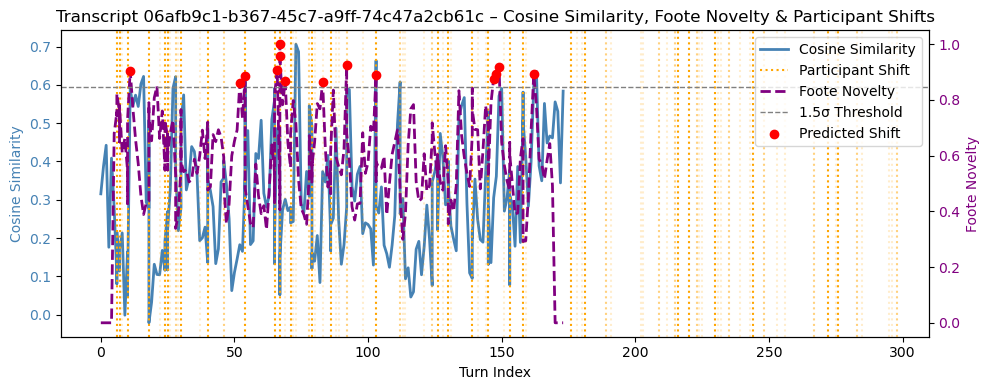

In [20]:
# now overlap the foote novelty and cosine similarity with participant annotations
example_transcripts = dense['transcript_id'].unique()[:5]

for tid in example_transcripts:
    # get cosine similarity values from 3 tiled windows
    cos_df = df[df['transcript_id'] == tid].sort_values('A_start_turn').reset_index(drop=True)
    
    # get foote novelty from new foote_df data frame
    nov_df = foote_df[foote_df['transcript_id'] == tid].copy()
    
    # map novelty points to the first turn in their 3-utterance cluster (to account for A_start_turn etc)
    nov_df['plot_turn'] = nov_df['turn_index'].map(
        dict(zip(range(len(dense[dense['transcript_id']==tid])), 
                 dense[dense['transcript_id']==tid]['turn_id'])))
    
    # align lengths
    min_len = min(len(cos_df), len(nov_df))
    cos_vals = cos_df['cosine_similarity'].values[:min_len]
    nov_vals = nov_df['foote_novelty'].values[:min_len]
    predicted = nov_df['predicted_shift'].values[:min_len]
    turns = nov_df['plot_turn'].values[:min_len]  # use the mapped turn IDs for x-axis
    
    # determine the threshold for plotting
    threshold = nov_vals.mean() + 1.5 * nov_vals.std()
    
    # get participant annotations
    dense_transcript = dense[dense['transcript_id'] == tid]
    shift_counts = dense_transcript.groupby('turn_id')['new_topic'].apply(lambda x: x.notnull().sum())
    shift_counts = shift_counts[shift_counts > 0]  # only turns with at least 1 participant
    
    # keep only shifts within plotted range
    # triple check this, not sure it's doing what I want...
    #shift_counts = shift_counts[shift_counts.index.isin(turns)]
    
    # plot!
    fig, ax1 = plt.subplots(figsize=(10,4))
    
    # cosine similarity
    ax1.plot(turns, cos_vals, color='steelblue', lw=2, label='Cosine Similarity')
    ax1.set_xlabel('Turn Index')
    ax1.set_ylabel('Cosine Similarity', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    
    # foote novelty
    ax2 = ax1.twinx()
    ax2.plot(turns, nov_vals, color='purple', linestyle='--', lw=2, label='Foote Novelty')
    ax2.axhline(threshold, color='gray', ls='--', lw=1, label='1.5σ Threshold')
    ax2.set_ylabel('Foote Novelty', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # points of predicted shifts
    peak_idx = np.where(predicted == 1)[0]
    ax2.scatter(turns[peak_idx], nov_vals[peak_idx], color='red', zorder=5, label='Predicted Shift')
    
    # participant-determined topic shifts with alpha for number of annotators
    plotted_first = False
    for turn, count in shift_counts.items():
        alpha = 0.2 if count == 1 else 0.5 if count == 2 else 1.0
        ax1.axvline(x=turn, color='orange', linestyle=':', lw=1.5,
                    alpha=alpha, label='Participant Shift' if not plotted_first else "")
        plotted_first = True
    
    # create title and legend
    plt.title(f'Transcript {tid} – Cosine Similarity, Foote Novelty & Participant Shifts')
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()



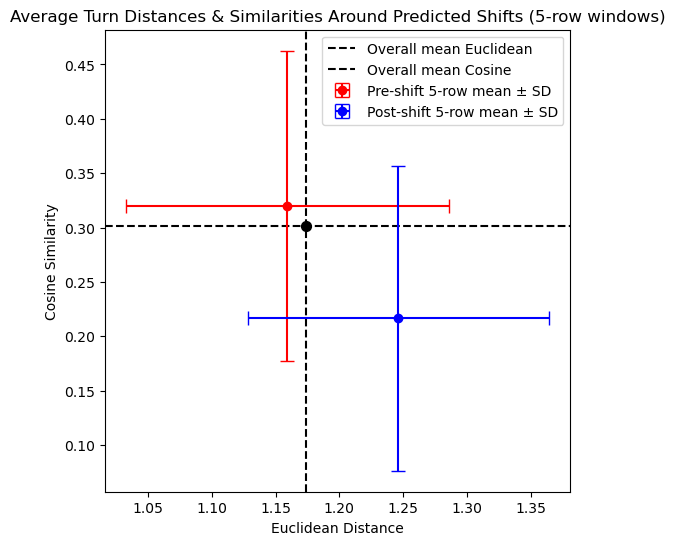

In [18]:
# now get the average turn angle and step length overall and for utterances before and after predicted shifts

window_size = 5  # number of rows before/after predicted shift to average

pre_shift_rows = []
post_shift_rows = []

for tid, group in foote_df.groupby('transcript_id'):
    group = group.sort_values('turn_index').reset_index(drop=True)
    predicted_idx = np.where(group['predicted_shift'] == 1)[0]
    
    df_transcript = df[df['transcript_id'] == tid]
    
    for idx in predicted_idx:
        # --- Pre-shift window ---
        start_pre = max(0, idx - window_size)
        pre_window = group.iloc[start_pre:idx]
        
        for _, row in pre_window.iterrows():
            match = df_transcript[(df_transcript['A_start_turn'] <= row['turn_index']) &
                                  (df_transcript['B_end_turn'] >= row['turn_index'])]
            if not match.empty:
                pre_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })
        
        # --- Post-shift window ---
        end_post = min(len(group), idx + 1 + window_size)
        post_window = group.iloc[idx+1:end_post]
        
        for _, row in post_window.iterrows():
            match = df_transcript[(df_transcript['A_start_turn'] <= row['turn_index']) &
                                  (df_transcript['B_end_turn'] >= row['turn_index'])]
            if not match.empty:
                post_shift_rows.append({
                    'euclidean_distance': match['euclidean_distance'].values[0],
                    'cosine_similarity': match['cosine_similarity'].values[0]
                })

# Combine into DataFrames
pre_shift_df = pd.DataFrame(pre_shift_rows).dropna()
post_shift_df = pd.DataFrame(post_shift_rows).dropna()

# Compute mean and SD
pre_mean_euc, pre_sd_euc = pre_shift_df['euclidean_distance'].mean(), pre_shift_df['euclidean_distance'].std()
pre_mean_cos, pre_sd_cos = pre_shift_df['cosine_similarity'].mean(), pre_shift_df['cosine_similarity'].std()

post_mean_euc, post_sd_euc = post_shift_df['euclidean_distance'].mean(), post_shift_df['euclidean_distance'].std()
post_mean_cos, post_sd_cos = post_shift_df['cosine_similarity'].mean(), post_shift_df['cosine_similarity'].std()

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Overall mean lines
ax.axvline(df['euclidean_distance'].mean(), color='black', linestyle='--', label='Overall mean Euclidean')
ax.axhline(df['cosine_similarity'].mean(), color='black', linestyle='--', label='Overall mean Cosine')

# Intersection point
ax.scatter(df['euclidean_distance'].mean(), df['cosine_similarity'].mean(), color='black', s=50, zorder=5)

# Pre-shift window mean ± SD
ax.errorbar(pre_mean_euc, pre_mean_cos,
            xerr=pre_sd_euc, yerr=pre_sd_cos,
            fmt='o', color='red', ecolor='red', capsize=5,
            label=f'Pre-shift {window_size}-row mean ± SD')

# Post-shift window mean ± SD
ax.errorbar(post_mean_euc, post_mean_cos,
            xerr=post_sd_euc, yerr=post_sd_cos,
            fmt='o', color='blue', ecolor='blue', capsize=5,
            label=f'Post-shift {window_size}-row mean ± SD')

ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Cosine Similarity')
ax.set_title(f'Average Turn Distances & Similarities Around Predicted Shifts ({window_size}-row windows)')
ax.legend()
plt.show()



## Cosine of the turn angle

Cosine angle ≈ 0 --> 

In [4]:
def compute_turn_angles_adjacent_windows(df):
    results = []

    # group by transcript
    for transcript_id, group in df.groupby('transcript_id'):
        if len(group) < 2:
            continue  # need at least 2 windows to compute a turn
        
        # stack the embeddings to ensure 2D arrays (number of points, embedding dimension)
        A = np.vstack([emb.squeeze() for emb in group['A_embeddings'].values[:-1]])
        B = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[:-1]])
        C = np.vstack([emb.squeeze() for emb in group['B_embeddings'].values[1:]])
        
        # compute vectors from the middle point (B)
        BA = A - B
        BC = C - B
        
        # calculate cosine similarity
        cos_theta = np.array([cosine_similarity(BA[i].reshape(1,-1), BC[i].reshape(1,-1))[0,0]
                              for i in range(len(BA))])
        
        # save results for this transcript
        res_df = pd.DataFrame({
            'transcript_id': transcript_id,
            'turn_index': np.arange(len(cos_theta)),  # starts at 0
            'cosine_turn': cos_theta
        })
        results.append(res_df)
    
    # combine all transcripts
    return pd.concat(results, ignore_index=True)


In [5]:
angles_df = compute_turn_angles_adjacent_windows(df)
print(angles_df.head())

                          transcript_id  turn_index  cosine_turn
0  0020a0c5-1658-4747-99c1-2839e736b481           0     0.358939
1  0020a0c5-1658-4747-99c1-2839e736b481           1    -0.267124
2  0020a0c5-1658-4747-99c1-2839e736b481           2    -0.091360
3  0020a0c5-1658-4747-99c1-2839e736b481           3     0.196351
4  0020a0c5-1658-4747-99c1-2839e736b481           4     0.332365


In [ ]:
def compute_foote_novelty(embeddings, kernel_size=10):
    """
    Compute Foote novelty curve from a sequence of embeddings.

    embeddings: np.ndarray of shape (n_turns, embedding_dim)
    kernel_size: int, must be even, controls local window width
    """
    n = len(embeddings)
    if n < kernel_size:
        return np.zeros(n)

    # Step 1: Compute self-similarity matrix (cosine)
    S = cosine_similarity(embeddings)
    
    # Step 2: Build checkerboard kernel
    k = kernel_size // 2
    kernel = np.block([
        [np.ones((k, k)), -np.ones((k, k))],
        [-np.ones((k, k)), np.ones((k, k))]
    ])
    
    # Normalize kernel
    kernel = kernel / np.sqrt((kernel_size ** 2) / 2)
    
    # Step 3: Convolve along the main diagonal
    novelty = np.zeros(n)
    for i in range(k, n - k):
        sub = S[i - k:i + k, i - k:i + k]
        novelty[i] = np.sum(sub * kernel)
    
    # Normalize to [0,1]
    novelty = (novelty - novelty.min()) / (novelty.max() - novelty.min() + 1e-8)
    return novelty


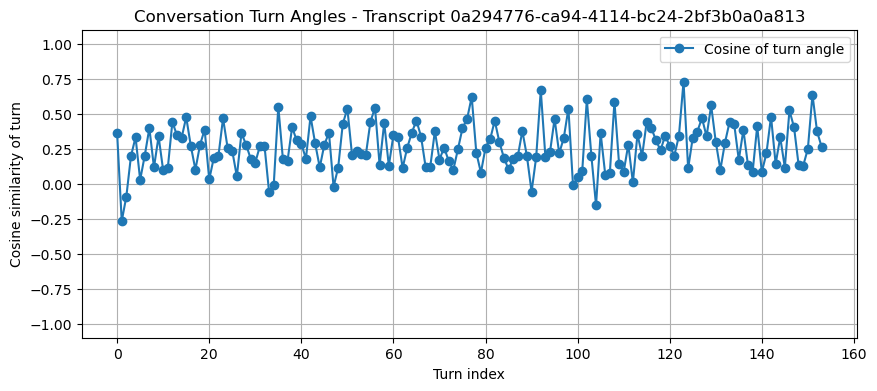

In [25]:
example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

# Plot cosine of turn angles
plt.figure(figsize=(10, 4))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', label='Cosine of turn angle')
plt.title(f"Conversation Turn Angles - Transcript {example_transcript}")
plt.xlabel("Turn index")
plt.ylabel("Cosine similarity of turn")
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.legend()
plt.show()


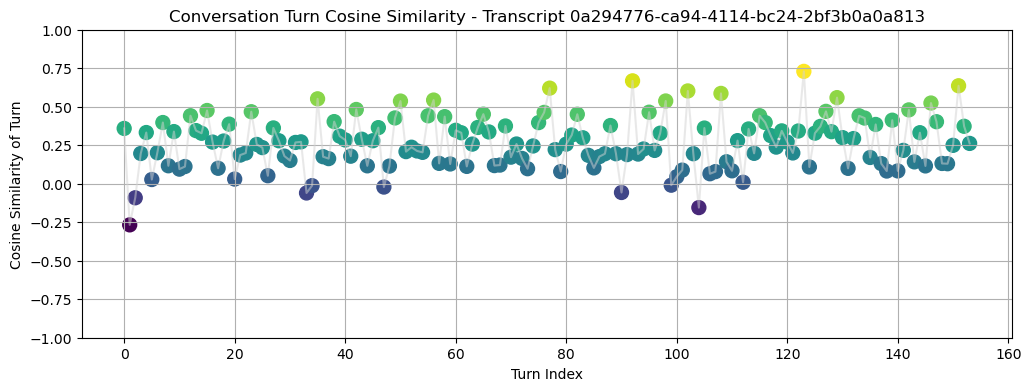

In [27]:
import matplotlib.cm as cm

example_transcript = "0a294776-ca94-4114-bc24-2bf3b0a0a813"
example_df = angles_df[angles_df['transcript_id'] == example_transcript]

norm = (example_df['cosine_turn'] - example_df['cosine_turn'].min()) / \
       (example_df['cosine_turn'].max() - example_df['cosine_turn'].min())
colors = cm.viridis(norm)

plt.figure(figsize=(12, 4))
plt.scatter(example_df['turn_index'], example_df['cosine_turn'], c=colors, s=100)
plt.plot(example_df['turn_index'], example_df['cosine_turn'], color='lightgray', alpha=0.5)
plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity of Turn")
plt.title(f"Conversation Turn Cosine Similarity - Transcript {example_transcript}")
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

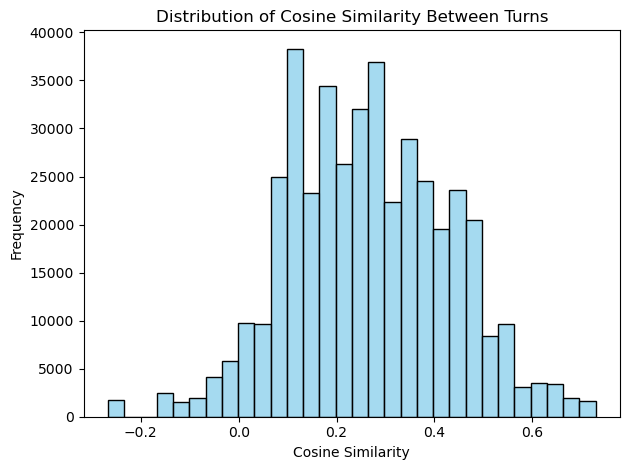

In [33]:
# distribution of cosine of turn similarity
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot
plt.tight_layout()
plt.show()

In [ ]:
# what's the cosine similarity of turn angles in the bottom 10% of the data?
threshold = np.percentile(angles_df['cosine_turn'], 10)
print("Threshold for large jumps (10th percentile):", threshold)
# cosine similarities lower than 0.079 are considered "big jumps"

Threshold for large jumps (10th percentile): 0.0790984183549881


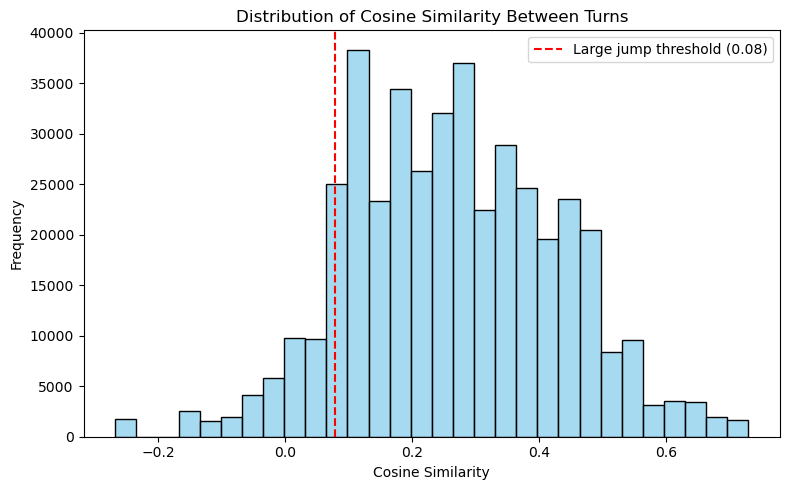

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(angles_df['cosine_turn'], bins=30, kde=False, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Large jump threshold ({threshold:.2f})')
plt.title('Distribution of Cosine Similarity Between Turns')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
example_transcript = angles_df['transcript_id'].iloc[0]
example_df = angles_df[angles_df['transcript_id'] == example_transcript].copy()

# Threshold for large jumps
threshold = np.percentile(angles_df['cosine_turn'], 10)
example_df['large_jump'] = example_df['cosine_turn'] < threshold

# Correctly assign turn_index aligned to the example transcript
example_df['turn_index'] = df.loc[df['transcript_id'] == example_transcript, 'A_start_turn'].iloc[1:1+len(example_df)].values

# Merge utterances
example_df = example_df.merge(
    df[['transcript_id', 'A_start_turn', 'A_utterances']],
    on=['transcript_id', 'A_start_turn'],
    how='left'
)

# Plot cosine similarity
plt.figure(figsize=(14, 5))
plt.plot(example_df['turn_index'], example_df['cosine_turn'], marker='o', color='skyblue', label='Cosine Similarity')

# Highlight large jumps
plt.scatter(example_df.loc[example_df['large_jump'], 'turn_index'],
            example_df.loc[example_df['large_jump'], 'cosine_turn'],
            color='red', s=100, label='Large Jump')

plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')

# Annotate utterances for large jumps
for idx, row in example_df[example_df['large_jump']].iterrows():
    plt.text(row['turn_index'], -0.15, row['A_utterances'], rotation=45, ha='right', va='top', fontsize=8, wrap=True)

plt.xlabel("Turn Index")
plt.ylabel("Cosine Similarity")
plt.title(f"Conversation Turn Cosine Similarity with Large Jumps & Utterances - Transcript {example_transcript}")
plt.ylim(-0.3, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'A_start_turn'

## Data checks

*Check number of annotated transcripts, see if there are any IDs that don't have an annotator*

### Foote Novelty

*To Do:*
1) look at peaks in distances across conversations to figure out foote novelty thresholds
2) take cosine of the angle between vectors (e.g., the distance between cosine of window 1 and window 2 and cosine of window 2 and window 3)


Do we just combine utterances from 1/2 and 2/3 to find distance between sets?
find periods where the similarity between windows is greater than similarity within